# Model Training

In [105]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report,accuracy_score, f1_score, auc
from sklearn.inspection import permutation_importance

from matplotlib import pyplot

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("./../data/input/ckd_processed.csv")

In [3]:
data.head(5)

,sg,al,rbc,hemo,pcv,class
0,3.0,1.0,0.8,15.4,44.0,0.0
1,3.0,4.0,0.6,11.3,38.0,0.0
2,1.0,2.0,1.0,9.6,31.0,0.0
3,0.0,4.0,1.0,11.2,32.0,0.0
4,1.0,2.0,1.0,11.6,35.0,0.0


### Split Dataset into Train, Test & Validate

In [74]:
training_features, testing_validation_features, training_labels, testing_validation_labels = train_test_split(data.iloc[:,:-1],
                                                                                        data['class'],
                                                                                        test_size = 0.30,
                                                                                        random_state=94,
                                                                                        stratify= data['class'])

validation_features, testing_features, validation_labels, testing_labels = train_test_split(testing_validation_features,
                                                                                            testing_validation_labels,
                                                                                        test_size = 0.40,
                                                                                        random_state=94,
                                                                                        stratify= testing_validation_labels)

In [75]:
def generate_roc_curve(recall, precision, label):
    pyplot.plot(recall, precision, label=label, marker='.')
    pyplot.xlabel('Recall') 
    pyplot.ylabel('Precision')
    pyplot.legend()
    pyplot.show()

## Experimentation Lab

In [113]:
experiments = {"experiment_name": [],
               "best_score": [],
               "best_hyperparameters": [],
               "validation_classification_report": [],
               "validation_f1_score": [],
               "validation_auc_score": [],
               "testing_classification_report": [],
               "testing_f1_score": [],
               "testing_auc_score": []}

## Experiment 1 - Logistic Regression

#### Model Parameter Selection

Best score: 0.9741071428571428

Best hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

Classification report: 
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        45
         1.0       0.96      1.00      0.98        27

    accuracy                           0.99        72
   macro avg       0.98      0.99      0.99        72
weighted avg       0.99      0.99      0.99        72


Confusion matrix: 
[[44  1]
 [ 0 27]]



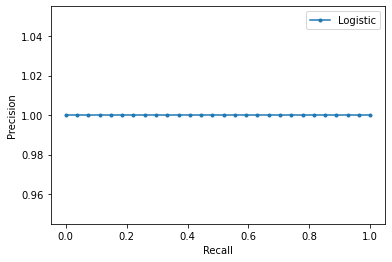

F1 Score: 0.9818181818181818	AUC: 0.9999999999999998



In [107]:
cv = RepeatedStratifiedKFold(n_splits=8, n_repeats=4, random_state=94)
search_param = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
                'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}
search = GridSearchCV(LogisticRegression(), search_param, scoring='accuracy', n_jobs=-1, cv=cv)
search.fit(training_features, training_labels)

print(f'Best score: {search.best_score_}\n')
print(f'Best hyperparameters: {search.best_params_}\n')

predicted_labels = search.predict(validation_features)
predicted_probs = search.predict_proba(validation_features)[:, 1]
print(f'Classification report: \n{classification_report(validation_labels, predicted_labels)}\n')
clf_report = classification_report(validation_labels, predicted_labels, output_dict=True)

confusion = confusion_matrix(validation_labels, predicted_labels)
print(f'Confusion matrix: \n{confusion}\n')

precision, recall, _ = precision_recall_curve(validation_labels, predicted_probs)
generate_roc_curve(recall, precision, "Logistic")

f1, auc_score = f1_score(validation_labels, predicted_labels), auc(recall, precision)
print(f"F1 Score: {f1}\tAUC: {auc_score}\n")

In [116]:
experiments["experiment_name"].append("Logistic Regression")
experiments["best_score"].append(search.best_score_)
experiments["best_hyperparameters"].append(search.best_params_)
experiments["validation_classification_report"].append(clf_report)
experiments["validation_f1_score"].append(f1)
experiments["validation_auc_score"].append(auc_score)

#### Final Model & Feature Importance

Text(0.5, 0, 'Importance')

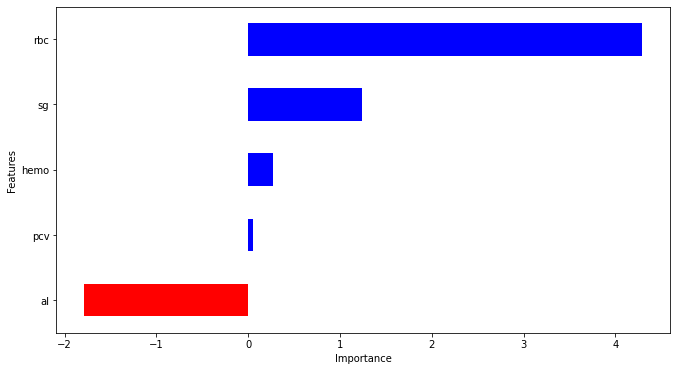

In [77]:
best_model = search.best_estimator_
features = pd.DataFrame()
features['Features'] = testing_features.columns.values.tolist()
features['importance'] = best_model.coef_[0].tolist()
features.sort_values(by=['importance'], ascending=True, inplace=True)
features['positive'] = features['importance'] > 0
features.set_index('Features', inplace=True)
features.importance.plot(kind='barh', figsize=(11, 6),color = features.positive.map({True: 'blue', False: 'red'}))
pyplot.xlabel('Importance')

#### Model Performance Test on Unseen Data

Classification report: 
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98        30
         1.0       1.00      0.94      0.97        18

    accuracy                           0.98        48
   macro avg       0.98      0.97      0.98        48
weighted avg       0.98      0.98      0.98        48


Confusion matrix: 
[[30  0]
 [ 1 17]]



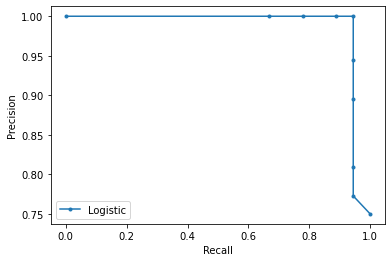

F1 Score: 0.9714285714285714	AUC: 0.9867424242424243



In [109]:
predicted_labels = best_model.predict(testing_features)
predicted_probs = best_model.predict_proba(testing_features)[:, 1]
print(f'Classification report: \n{classification_report(testing_labels, predicted_labels)}\n')
clf_report = classification_report(testing_labels, predicted_labels, output_dict=True)

confusion = confusion_matrix(testing_labels, predicted_labels)
print(f'Confusion matrix: \n{confusion}\n')

precision, recall, _ = precision_recall_curve(testing_labels, predicted_probs)
generate_roc_curve(recall, precision, "Logistic")

f1, auc_score = f1_score(testing_labels, predicted_labels), auc(recall, precision)
print(f"F1 Score: {f1}\tAUC: {auc_score}\n")

In [114]:
experiments["testing_classification_report"].append(clf_report)
experiments["testing_f1_score"].append(f1)
experiments["testing_auc_score"].append(auc_score)

## Experiment 2 - Support Vector Machine

#### Model Parameter Selection

Best score: 0.9741071428571428

Best hyperparameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Classification report: 
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98        45
         1.0       0.93      1.00      0.96        27

    accuracy                           0.97        72
   macro avg       0.97      0.98      0.97        72
weighted avg       0.97      0.97      0.97        72


Confusion matrix: 
[[43  2]
 [ 0 27]]



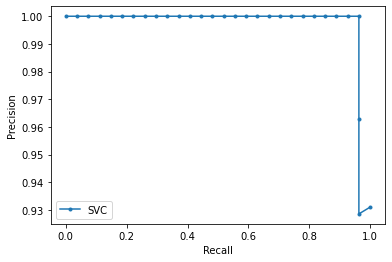

F1 Score: 0.9642857142857143	AUC: 0.9974001094690748



In [79]:
cv = RepeatedStratifiedKFold(n_splits=8, n_repeats=4, random_state=94)

search_param = {'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear']}

search = GridSearchCV(SVC(probability=True), search_param, scoring='accuracy', n_jobs=-1, cv=cv, refit = True)
search.fit(training_features, training_labels)

print(f'Best score: {search.best_score_}\n')
print(f'Best hyperparameters: {search.best_params_}\n')

predicted_labels = search.predict(validation_features)
predicted_probs = search.predict_proba(validation_features)[:, 1]
print(f'Classification report: \n{classification_report(validation_labels, predicted_labels)}\n')
clf_report = classification_report(validation_labels, predicted_labels, output_dict=True)

confusion = confusion_matrix(validation_labels, predicted_labels)
print(f'Confusion matrix: \n{confusion}\n')

precision, recall, _ = precision_recall_curve(validation_labels, predicted_probs)
generate_roc_curve(recall, precision, "SVC")

f1, auc_score = f1_score(validation_labels, predicted_labels), auc(recall, precision)
print(f"F1 Score: {f1}\tAUC: {auc_score}\n")

In [118]:
experiments["experiment_name"].append("Support Vector Machine")
experiments["best_score"].append(search.best_score_)
experiments["best_hyperparameters"].append(search.best_params_)
experiments["validation_classification_report"].append(clf_report)
experiments["validation_f1_score"].append(f1)
experiments["validation_auc_score"].append(auc_score)

#### Final Model & Feature Importance

Text(0.5, 0, 'Importance')

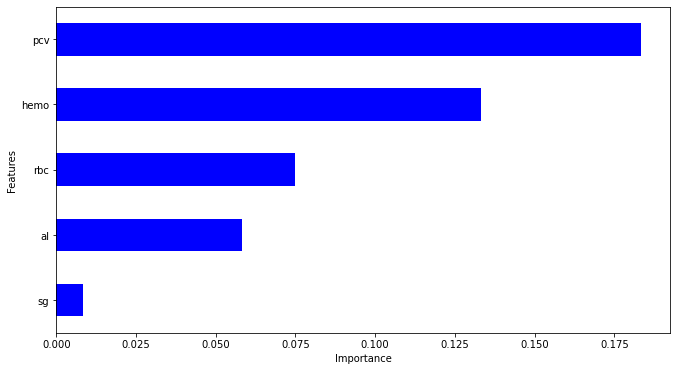

In [80]:
best_model = search.best_estimator_
features = pd.DataFrame()
features['Features'] = validation_features.columns.values.tolist()
perm_importance = permutation_importance(best_model, validation_features, validation_labels)
sorted_idx = perm_importance.importances_mean.argsort()
features['importance'] = perm_importance.importances_mean[sorted_idx]
features.sort_values(by=['importance'], ascending=True, inplace=True)
features['positive'] = features['importance'] > 0
features.set_index('Features', inplace=True)
features.importance.plot(kind='barh', figsize=(11, 6),color = features.positive.map({True: 'blue', False: 'red'}))
pyplot.xlabel('Importance')

#### Model Performance Test on Unseen Data

Classification report: 
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98        30
         1.0       1.00      0.94      0.97        18

    accuracy                           0.98        48
   macro avg       0.98      0.97      0.98        48
weighted avg       0.98      0.98      0.98        48


Confusion matrix: 
[[30  0]
 [ 1 17]]



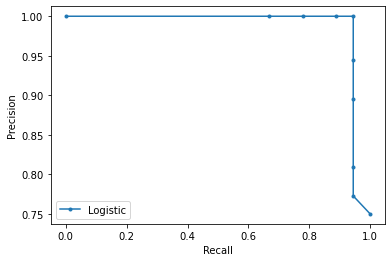

F1 Score: 0.9714285714285714	AUC: 0.9867424242424243



In [119]:
predicted_labels = best_model.predict(testing_features)
predicted_probs = best_model.predict_proba(testing_features)[:, 1]
print(f'Classification report: \n{classification_report(testing_labels, predicted_labels)}\n')
clf_report = classification_report(testing_labels, predicted_labels, output_dict=True)

confusion = confusion_matrix(testing_labels, predicted_labels)
print(f'Confusion matrix: \n{confusion}\n')

precision, recall, _ = precision_recall_curve(testing_labels, predicted_probs)
generate_roc_curve(recall, precision, "Logistic")

f1, auc_score = f1_score(testing_labels, predicted_labels), auc(recall, precision)
print(f"F1 Score: {f1}\tAUC: {auc_score}\n")

In [120]:
experiments["testing_classification_report"].append(clf_report)
experiments["testing_f1_score"].append(f1)
experiments["testing_auc_score"].append(auc_score)

## Experiment 3 - Decision Tree

#### Model Parameter Selection

Best score: 0.9696428571428571

Best hyperparameters: {'max_leaf_nodes': 67, 'min_samples_split': 2}

Classification report: 
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        45
         1.0       0.96      1.00      0.98        27

    accuracy                           0.99        72
   macro avg       0.98      0.99      0.99        72
weighted avg       0.99      0.99      0.99        72


Confusion matrix: 
[[44  1]
 [ 0 27]]



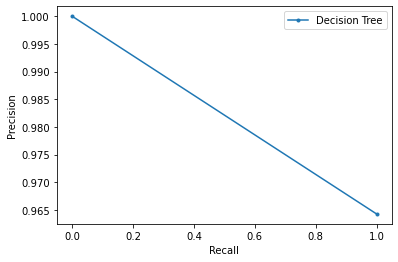

F1 Score: 0.9818181818181818	AUC: 0.9821428571428572



In [121]:
cv = RepeatedStratifiedKFold(n_splits=8, n_repeats=4, random_state=94)

search_param = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}

search = GridSearchCV(DecisionTreeClassifier(), search_param, scoring='accuracy', n_jobs=-1, cv=cv, refit = True)
search.fit(training_features, training_labels)

print(f'Best score: {search.best_score_}\n')
print(f'Best hyperparameters: {search.best_params_}\n')

predicted_labels = search.predict(validation_features)
predicted_probs = search.predict_proba(validation_features)[:, 1]
print(f'Classification report: \n{classification_report(validation_labels, predicted_labels)}\n')
clf_report = classification_report(validation_labels, predicted_labels, output_dict=True)

confusion = confusion_matrix(validation_labels, predicted_labels)
print(f'Confusion matrix: \n{confusion}\n')

precision, recall, _ = precision_recall_curve(validation_labels, predicted_probs)
generate_roc_curve(recall, precision, "Decision Tree")

f1, auc_score = f1_score(validation_labels, predicted_labels), auc(recall, precision)
print(f"F1 Score: {f1}\tAUC: {auc_score}\n")

In [122]:
experiments["experiment_name"].append("Decision Tree")
experiments["best_score"].append(search.best_score_)
experiments["best_hyperparameters"].append(search.best_params_)
experiments["validation_classification_report"].append(clf_report)
experiments["validation_f1_score"].append(f1)
experiments["validation_auc_score"].append(auc_score)

#### Final Model & Feature Importance

Text(0.5, 0, 'Importance')

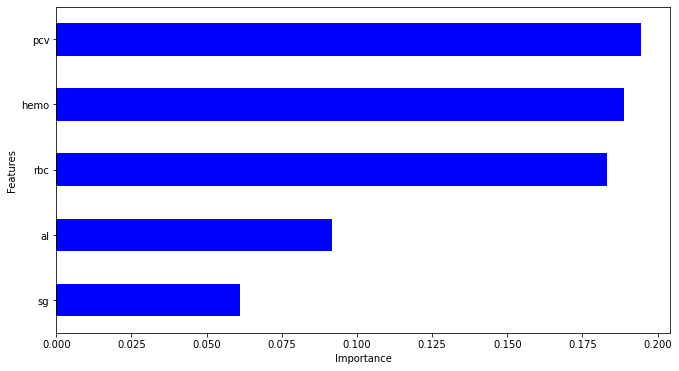

In [92]:
best_model = search.best_estimator_
features = pd.DataFrame()
features['Features'] = validation_features.columns.values.tolist()
perm_importance = permutation_importance(best_model, validation_features, validation_labels)
sorted_idx = perm_importance.importances_mean.argsort()
features['importance'] = perm_importance.importances_mean[sorted_idx]
features.sort_values(by=['importance'], ascending=True, inplace=True)
features['positive'] = features['importance'] > 0
features.set_index('Features', inplace=True)
features.importance.plot(kind='barh', figsize=(11, 6),color = features.positive.map({True: 'blue', False: 'red'}))
pyplot.xlabel('Importance')

#### Model Performance Test on Unseen Data

Classification report: 
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98        30
         1.0       1.00      0.94      0.97        18

    accuracy                           0.98        48
   macro avg       0.98      0.97      0.98        48
weighted avg       0.98      0.98      0.98        48


Confusion matrix: 
[[30  0]
 [ 1 17]]



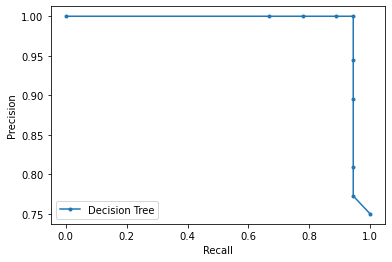

F1 Score: 0.9714285714285714	AUC: 0.9867424242424243



In [123]:
predicted_labels = best_model.predict(testing_features)
predicted_probs = best_model.predict_proba(testing_features)[:, 1]
print(f'Classification report: \n{classification_report(testing_labels, predicted_labels)}\n')
clf_report = classification_report(testing_labels, predicted_labels, output_dict=True)

confusion = confusion_matrix(testing_labels, predicted_labels)
print(f'Confusion matrix: \n{confusion}\n')

precision, recall, _ = precision_recall_curve(testing_labels, predicted_probs)
generate_roc_curve(recall, precision, "Decision Tree")

f1, auc_score = f1_score(testing_labels, predicted_labels), auc(recall, precision)
print(f"F1 Score: {f1}\tAUC: {auc_score}\n")

In [124]:
experiments["testing_classification_report"].append(clf_report)
experiments["testing_f1_score"].append(f1)
experiments["testing_auc_score"].append(auc_score)

## Experiment 4 - Random Forest

#### Model Parameter Selection

Best score: 0.9830357142857143

Best hyperparameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 29}

Classification report: 
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        45
         1.0       0.96      1.00      0.98        27

    accuracy                           0.99        72
   macro avg       0.98      0.99      0.99        72
weighted avg       0.99      0.99      0.99        72


Confusion matrix: 
[[44  1]
 [ 0 27]]



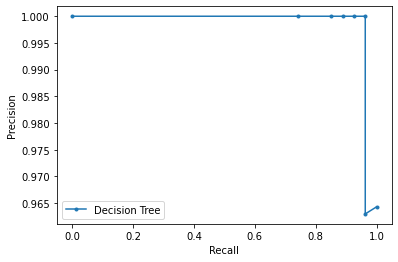

F1 Score: 0.9818181818181818	AUC: 0.9986527532823829



In [125]:
cv = RepeatedStratifiedKFold(n_splits=8, n_repeats=4, random_state=94)

search_param = { 
    'n_estimators': list(range(8, 36)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : list(range(2, 9)),
    'criterion' :['gini', 'entropy']
}

search = GridSearchCV(RandomForestClassifier(), search_param, scoring='accuracy', n_jobs=-1, cv=cv, refit = True)
search.fit(training_features, training_labels)

print(f'Best score: {search.best_score_}\n')
print(f'Best hyperparameters: {search.best_params_}\n')

predicted_labels = search.predict(validation_features)
predicted_probs = search.predict_proba(validation_features)[:, 1]
print(f'Classification report: \n{classification_report(validation_labels, predicted_labels)}\n')
clf_report = classification_report(validation_labels, predicted_labels, output_dict=True)

confusion = confusion_matrix(validation_labels, predicted_labels)
print(f'Confusion matrix: \n{confusion}\n')

precision, recall, _ = precision_recall_curve(validation_labels, predicted_probs)
generate_roc_curve(recall, precision, "Decision Tree")

f1, auc_score = f1_score(validation_labels, predicted_labels), auc(recall, precision)
print(f"F1 Score: {f1}\tAUC: {auc_score}\n")

In [126]:
experiments["experiment_name"].append("Random Forest")
experiments["best_score"].append(search.best_score_)
experiments["best_hyperparameters"].append(search.best_params_)
experiments["validation_classification_report"].append(clf_report)
experiments["validation_f1_score"].append(f1)
experiments["validation_auc_score"].append(auc_score)

#### Final Model & Feature Importance

Text(0.5, 0, 'Importance')

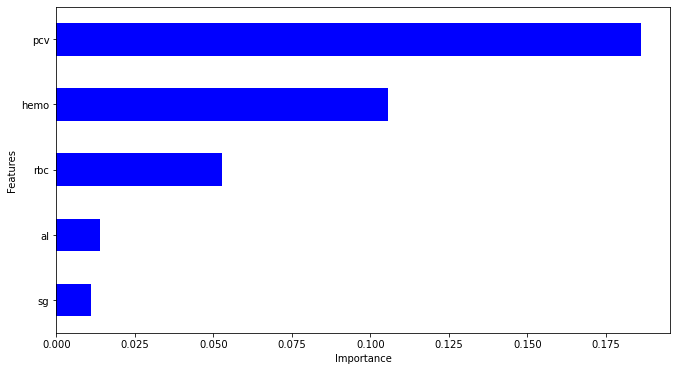

In [96]:
best_model = search.best_estimator_
features = pd.DataFrame()
features['Features'] = validation_features.columns.values.tolist()
perm_importance = permutation_importance(best_model, validation_features, validation_labels)
sorted_idx = perm_importance.importances_mean.argsort()
features['importance'] = perm_importance.importances_mean[sorted_idx]
features.sort_values(by=['importance'], ascending=True, inplace=True)
features['positive'] = features['importance'] > 0
features.set_index('Features', inplace=True)
features.importance.plot(kind='barh', figsize=(11, 6),color = features.positive.map({True: 'blue', False: 'red'}))
pyplot.xlabel('Importance')

#### Model Performance Test on Unseen Data

Classification report: 
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98        30
         1.0       1.00      0.94      0.97        18

    accuracy                           0.98        48
   macro avg       0.98      0.97      0.98        48
weighted avg       0.98      0.98      0.98        48


Confusion matrix: 
[[30  0]
 [ 1 17]]



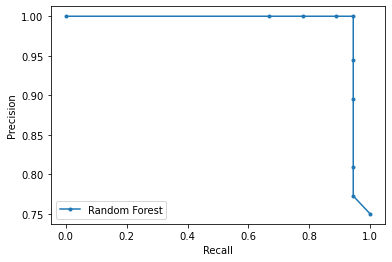

F1 Score: 0.9714285714285714	AUC: 0.9867424242424243



In [127]:
predicted_labels = best_model.predict(testing_features)
predicted_probs = best_model.predict_proba(testing_features)[:, 1]
print(f'Classification report: \n{classification_report(testing_labels, predicted_labels)}\n')
clf_report = classification_report(testing_labels, predicted_labels, output_dict=True)

confusion = confusion_matrix(testing_labels, predicted_labels)
print(f'Confusion matrix: \n{confusion}\n')

precision, recall, _ = precision_recall_curve(testing_labels, predicted_probs)
generate_roc_curve(recall, precision, "Random Forest")

f1, auc_score = f1_score(testing_labels, predicted_labels), auc(recall, precision)
print(f"F1 Score: {f1}\tAUC: {auc_score}\n")

In [128]:
experiments["testing_classification_report"].append(clf_report)
experiments["testing_f1_score"].append(f1)
experiments["testing_auc_score"].append(auc_score)

## Lab Analysis

In [129]:
experiments_df = pd.DataFrame(experiments)

In [131]:
experiments_df

,experiment_name,best_score,best_hyperparameters,validation_classification_report,validation_f1_score,validation_auc_score,testing_classification_report,testing_f1_score,testing_auc_score
0,Logistic Regression,0.974107,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}","{'0.0': {'precision': 0.967741935483871, 'reca...",0.971429,0.986742,"{'0.0': {'precision': 0.967741935483871, 'reca...",0.971429,0.986742
1,Support Vector Machine,0.974107,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}","{'0.0': {'precision': 0.967741935483871, 'reca...",0.971429,0.986742,"{'0.0': {'precision': 0.967741935483871, 'reca...",0.971429,0.986742
2,Decision Tree,0.969643,"{'max_leaf_nodes': 67, 'min_samples_split': 2}","{'0.0': {'precision': 1.0, 'recall': 0.9777777...",0.981818,0.982143,"{'0.0': {'precision': 0.967741935483871, 'reca...",0.971429,0.986742
3,Random Forest,0.983036,"{'criterion': 'gini', 'max_depth': 8, 'max_fea...","{'0.0': {'precision': 1.0, 'recall': 0.9777777...",0.981818,0.998653,"{'0.0': {'precision': 0.967741935483871, 'reca...",0.971429,0.986742


In [133]:
experiments_df.to_csv("./../data/output/Lab_Experiments_Data.csv")